# Notebook dependencies

In [1]:
import pandas as pd
import numpy as np
import os.path

import networkx as nx
from sklearn import preprocessing
from scipy.stats import spearmanr

import itertools
from hashlib import md5
import pycountry_convert

import matplotlib.pyplot as plt
import plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.io as pio
init_notebook_mode(connected=True)


# Setting pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

Let's also create a couple of utility functions

In [2]:
def country_to_countrycode(country):
    if pd.isna(country):
        return np.nan
    else:
        try:
            return pycountry_convert.country_name_to_country_alpha2(country)
        except:
            return np.nan
        
def countrycode_to_continent(country_code):
    if pd.isna(country_code):
        return np.nan
    else:
        try:
            return pycountry_convert.country_alpha2_to_continent_code(country_code)
        except:
            return np.nan

# Data preparation

Load raw datasets for further analysis

In [3]:
chi = pd.read_json('./data/raw/chi_metadata/chi.txt', lines=True)
chi_ref = pd.read_json('./data/raw/chi_metadata/chi_ref.txt', lines=True)
chi_cite = pd.read_json('./data/raw/chi_metadata/chi_cite.txt', lines=True)

Filter the papers without DOI and related referenced/citing ones

In [4]:
chi = chi.loc[(chi.doi != '') & (chi.year != 2019) & (chi.year >= 1982)]
chi_ref = chi_ref.loc[chi_ref.citingid.isin(chi.paperid)]
chi_cite = chi_cite.loc[chi_cite.citedid.isin(chi.paperid)]

Let's now resolve evey single contribution for each paper. (This will take some time...)

In [5]:
chi_contributions = chi[['paperid', 'authors', 'year']]
chi_contributions.head()

,paperid,authors,year
3,1964652812,"[{'order': 1, 'authorid': 2273923945, 'name': 'kaping yee', 'gridid': 'grid.47840.3f', 'affiliation': 'University of California, Berkeley', 'country': 'United States'}]",2004
4,1965508913,"[{'order': 1, 'authorid': 2289485431, 'name': 'graham a wilson', 'gridid': 'grid.8756.c', 'affiliation': 'University of Glasgow', 'country': 'United Kingdom'}, {'order': 3, 'authorid': 2157782254, 'name': 'stephen a brewster', 'gridid': 'grid.8756.c', 'affiliation': 'University of Glasgow', 'country': 'United Kingdom'}, {'order': 2, 'authorid': 2153905267, 'name': 'david hannah', 'gridid': 'grid.8756.c', 'affiliation': 'University of Glasgow', 'country': 'United Kingdom'}, {'order': 4, 'auth...",2012
5,1966171146,"[{'order': 1, 'authorid': 254673778, 'name': 'jean b gasen', 'gridid': 'grid.224260.0', 'affiliation': 'Virginia Commonwealth University', 'country': 'United States'}]",1999
6,1966518476,"[{'order': 3, 'authorid': 2666359173, 'name': 'xianjun sam zheng', 'gridid': 'grid.35403.31', 'affiliation': 'University of Illinois at Urbana Champaign', 'country': 'United States'}, {'order': 2, 'authorid': 2156317476, 'name': 'piotr d adamczyk', 'gridid': 'grid.35403.31', 'affiliation': 'University of Illinois at Urbana Champaign', 'country': 'United States'}, {'order': 4, 'authorid': 2100582521, 'name': 'brian p bailey', 'gridid': 'grid.35403.31', 'affiliation': 'University of Illinois a...",2005
7,1967761207,"[{'order': 1, 'authorid': 2309440540, 'name': 'alonso h vera', 'gridid': 'grid.194645.b', 'affiliation': 'University of Hong Kong', 'country': 'China'}, {'order': 2, 'authorid': 253752043, 'name': 'thomas kvan', 'gridid': 'grid.194645.b', 'affiliation': 'University of Hong Kong', 'country': 'China'}, {'order': 3, 'authorid': 2120303556, 'name': 'robert l west', 'gridid': 'grid.194645.b', 'affiliation': 'University of Hong Kong', 'country': 'China'}, {'order': 4, 'authorid': 2649293674, 'name...",1998


In [6]:
chi_contributions = chi_contributions.join(chi_contributions.authors.apply(pd.Series)) \
                                         .drop(columns='authors') \
                                         .melt(id_vars=['paperid', 'year'], value_name="author") \
                                         .drop(columns='variable') \
                                         .dropna() \
                                         .sort_values(by='paperid')
chi_contributions.head()

,paperid,year,author
58161,101198059,2013,"{'order': 3, 'authorid': 166732564, 'name': 'olivier chapuis', 'gridid': 'grid.5328.c', 'affiliation': 'French Institute for Research in Computer Science and Automation', 'country': 'France'}"
42423,101198059,2013,"{'order': 2, 'authorid': 2111668110, 'name': 'petra isenberg', 'gridid': 'grid.5328.c', 'affiliation': 'French Institute for Research in Computer Science and Automation', 'country': 'France'}"
10947,101198059,2013,"{'order': 1, 'authorid': 2676222217, 'name': 'anastasia bezerianos'}"
26685,101198059,2013,"{'order': 4, 'authorid': 2085234058, 'name': 'wesley willett', 'gridid': 'grid.5328.c', 'affiliation': 'French Institute for Research in Computer Science and Automation', 'country': 'France'}"
10503,246191141,2015,"{'order': 1, 'authorid': 2091341478, 'name': 'mark cartwright', 'gridid': 'grid.16753.36', 'affiliation': 'Northwestern University', 'country': 'United States'}"


In [7]:
chi_contributions = chi_contributions.join(chi_contributions.author.apply(pd.Series)) \
                                         .drop(columns='author') \
                                         .sort_values(by='paperid')
#                                         .dropna()
chi_contributions['countrycode'] = chi_contributions.country.map(country_to_countrycode)
chi_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
58161,101198059,2013,3,166732564,olivier chapuis,grid.5328.c,French Institute for Research in Computer Science and Automation,France,FR
42423,101198059,2013,2,2111668110,petra isenberg,grid.5328.c,French Institute for Research in Computer Science and Automation,France,FR
10947,101198059,2013,1,2676222217,anastasia bezerianos,NaN,NaN,NaN,NaN
26685,101198059,2013,4,2085234058,wesley willett,grid.5328.c,French Institute for Research in Computer Science and Automation,France,FR
10503,246191141,2015,1,2091341478,mark cartwright,grid.16753.36,Northwestern University,United States,US


In [8]:
PICKLE_PATH = './data/interim/chi_ref_contributions.pkl'
if os.path.isfile(PICKLE_PATH):
    chi_ref_contributions = pd.read_pickle(PICKLE_PATH)
else:
    chi_ref_contributions = chi_ref[['paperid', 'authors', 'year']]
    chi_ref_contributions = chi_ref_contributions.join(chi_ref_contributions.authors.apply(pd.Series)) \
                                            .drop(columns='authors') \
                                            .melt(id_vars=['paperid', 'year'], value_name="author") \
                                            .drop(columns='variable') \
                                            .dropna() \
                                            .sort_values(by='paperid')
    chi_ref_contributions = chi_ref_contributions.join(chi_ref_contributions.author.apply(pd.Series)) \
                                            .drop(columns='author') \
                                            .sort_values(by='paperid') \
    #                                         .dropna()
    chi_ref_contributions['countrycode'] = chi_ref_contributions.country.map(country_to_countrycode)
    chi_ref_contributions.to_pickle('./data/interim/chi_ref_contributions.pkl')
    
chi_ref_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
684472,25464,2007,3,2113883066,anthony jameson,grid.17272.31,German Research Centre for Artificial Intelligence,Germany,DE
928773,25464,2007,1,2806818281,antti oulasvirta,grid.473031.2,Deutsche Telekom (United Kingdom),United Kingdom,GB
195870,25464,2007,4,2097331944,sebastian moller,NaN,NaN,NaN,NaN
440171,25464,2007,2,2727622373,kp engelbrecht,grid.473031.2,Deutsche Telekom (United Kingdom),United Kingdom,GB
47308,44435,1997,2,2194603881,s w fan,NaN,NaN,NaN,NaN


In [9]:
PICKLE_PATH = './data/interim/chi_cite_contributions.pkl'
if os.path.isfile(PICKLE_PATH):
    chi_cite_contributions = pd.read_pickle(PICKLE_PATH)
else:
    chi_cite_contributions = chi_cite[['paperid', 'authors', 'year']]
    chi_cite_contributions = chi_cite_contributions.join(chi_cite_contributions.authors.apply(pd.Series)) \
                                            .drop(columns='authors') \
                                            .melt(id_vars=['paperid', 'year'], value_name="author") \
                                            .drop(columns='variable') \
                                            .dropna() \
                                            .sort_values(by='paperid')
    chi_cite_contributions = chi_cite_contributions.join(chi_cite_contributions.author.apply(pd.Series)) \
                                            .drop(columns='author') \
                                            .sort_values(by='paperid') \
    #                                         .dropna()
    chi_cite_contributions['countrycode'] = chi_cite_contributions.country.map(country_to_countrycode)
    chi_cite_contributions.to_pickle('./data/interim/chi_cite_contributions.pkl')
    
chi_cite_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
1318028,25464,2007,1,2806818281,antti oulasvirta,grid.473031.2,Deutsche Telekom (United Kingdom),United Kingdom,GB
471028,25464,2007,2,2727622373,kp engelbrecht,grid.473031.2,Deutsche Telekom (United Kingdom),United Kingdom,GB
894528,25464,2007,3,2113883066,anthony jameson,grid.17272.31,German Research Centre for Artificial Intelligence,Germany,DE
47528,25464,2007,4,2097331944,sebastian moller,NaN,NaN,NaN,NaN
363789,27257,2008,1,2119660283,nicole forsgren velasquez,NaN,NaN,NaN,NaN


Load external datasets for affiliation analysis (grid IDs and country centroids)

In [10]:
grid_df = pd.read_csv('./data/external/grid.csv')
grid_df.Country.replace({'State of Palestine': 'Palestine',
                         'Reunion': 'Réunion',
                         'Aland Islands': 'Åland Islands',
                         'Curacao': 'Curaçao'}, inplace=True)
grid_df['Countrycode'] = grid_df['Country'].map(lambda country: country_to_countrycode(country))
grid_df.head()

,ID,Name,City,State,Country,Countrycode
0,grid.1001.0,Australian National University,Canberra,Australian Capital Territory,Australia,AU
1,grid.1002.3,Monash University,Melbourne,Victoria,Australia,AU
2,grid.1003.2,University of Queensland,Brisbane,Queensland,Australia,AU
3,grid.1004.5,Macquarie University,Sydney,New South Wales,Australia,AU
4,grid.1005.4,UNSW Australia,Sydney,New South Wales,Australia,AU


In [11]:
centroids = pd.read_csv('./data/external/country_centroids_az8.csv')
additional_centroids = pd.DataFrame(data=[['GP', 29.030833, -118.28],
                                          ['RE', -21.114444, 55.5325],
                                          ['BQ', 12.183333, -68.25],
                                          ['MQ', 4.666667, -61.0],
                                          ['TV', -8.520833, 179.198611],
                                          ['NA', -22.0, 17.0],
                                          ['GF', 4.0, -53.0],
                                          ['XK', 42.583333, 21.0]],
                           columns=['iso_a2', 'Latitude', 'Longitude'])
centroids = centroids.append(additional_centroids, sort=False)
centroids.head()

,FID,the_geom,FID_,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,geounit,gu_a3,su_dif,subunit,su_a3,brk_diff,name,name_long,brk_a3,brk_name,brk_group,abbrev,postal,formal_en,formal_fr,note_adm0,note_brk,name_sort,name_alt,mapcolor7,mapcolor8,mapcolor9,mapcolor13,pop_est,gdp_md_est,pop_year,lastcensus,gdp_year,economy,income_grp,wikipedia,fips_10,iso_a2,iso_a3,iso_n3,un_a3,wb_a2,wb_a3,woe_id,adm0_a3_is,adm0_a3_us,adm0_a3_un,adm0_a3_wb,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,Longitude,Latitude
0,country_centroids_az8.1,POINT (-69.9826771125 12.5208803838),0.0,3.0,Admin-0 country,5.0,Netherlands,NL1,1.0,2.0,Country,Aruba,ABW,0.0,Aruba,ABW,0.0,Aruba,ABW,0.0,Aruba,Aruba,ABW,Aruba,NaN,Aruba,AW,Aruba,NaN,Neth.,NaN,Aruba,NaN,4.0,2.0,2.0,9.0,103065.0,2258.0,-99.0,2010.0,-99.0,6. Developing region,2. High income: nonOECD,-99.0,NaN,AW,ABW,533.0,533.0,AW,ABW,-99.0,ABW,ABW,-99.0,-99.0,North America,Americas,Caribbean,Latin America & Caribbean,5.0,5.0,5.0,4.0,-99.0,-69.982677,12.520880
1,country_centroids_az8.2,POINT (66.0047336558 33.8352307278),1.0,1.0,Admin-0 country,3.0,Afghanistan,AFG,0.0,2.0,Sovereign country,Afghanistan,AFG,0.0,Afghanistan,AFG,0.0,Afghanistan,AFG,0.0,Afghanistan,Afghanistan,AFG,Afghanistan,NaN,Afg.,AF,Islamic State of Afghanistan,NaN,NaN,NaN,Afghanistan,NaN,5.0,6.0,8.0,7.0,28400000.0,22270.0,-99.0,1979.0,-99.0,7. Least developed region,5. Low income,-99.0,NaN,AF,AFG,4.0,4.0,AF,AFG,-99.0,AFG,AFG,-99.0,-99.0,Asia,Asia,Southern Asia,South Asia,11.0,11.0,4.0,-99.0,1.0,66.004734,33.835231
2,country_centroids_az8.3,POINT (17.5373676815 -12.2933605438),2.0,1.0,Admin-0 country,3.0,Angola,AGO,0.0,2.0,Sovereign country,Angola,AGO,0.0,Angola,AGO,0.0,Angola,AGO,0.0,Angola,Angola,AGO,Angola,NaN,Ang.,AO,People's Republic of Angola,NaN,NaN,NaN,Angola,NaN,3.0,2.0,6.0,1.0,12799293.0,110300.0,-99.0,1970.0,-99.0,7. Least developed region,3. Upper middle income,-99.0,NaN,AO,AGO,24.0,24.0,AO,AGO,-99.0,AGO,AGO,-99.0,-99.0,Africa,Africa,Middle Africa,Sub-Saharan Africa,6.0,6.0,4.0,-99.0,1.0,17.537368,-12.293361
3,country_centroids_az8.4,POINT (-63.0649892654 18.2239595023),3.0,1.0,Admin-0 country,6.0,United Kingdom,GB1,1.0,2.0,Dependency,Anguilla,AIA,0.0,Anguilla,AIA,0.0,Anguilla,AIA,0.0,Anguilla,Anguilla,AIA,Anguilla,NaN,Ang.,AI,NaN,NaN,U.K.,NaN,Anguilla,NaN,6.0,6.0,6.0,3.0,14436.0,108.9,-99.0,-99.0,-99.0,6. Developing region,3. Upper middle income,-99.0,NaN,AI,AIA,660.0,660.0,-99,-99,-99.0,AIA,AIA,-99.0,-99.0,North America,Americas,Caribbean,Latin America & Caribbean,8.0,8.0,4.0,-99.0,-99.0,-63.064989,18.223959
4,country_centroids_az8.5,POINT (20.0498339611 41.1424498947),4.0,1.0,Admin-0 country,6.0,Albania,ALB,0.0,2.0,Sovereign country,Albania,ALB,0.0,Albania,ALB,0.0,Albania,ALB,0.0,Albania,Albania,ALB,Albania,NaN,Alb.,AL,Republic of Albania,NaN,NaN,NaN,Albania,NaN,1.0,4.0,1.0,6.0,3639453.0,21810.0,-99.0,2001.0,-99.0,6. Developing region,4. Lower middle income,-99.0,NaN,AL,ALB,8.0,8.0,AL,ALB,-99.0,ALB,ALB,-99.0,-99.0,Europe,Europe,Southern Europe,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,20.049834,41.142450


# Basic statistics

In [12]:
data = chi.groupby('year')['paperid'].count().reset_index()

trace = go.Bar(x=data['year'],
               y=data['paperid'])

layout = go.Layout(title='Papers published')

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_papers.png')

In [13]:
ref = pd.merge(left=chi_ref, right=chi, left_on='citingid', right_on='paperid', suffixes=('_ref','_chi'), how='right')
ref = ref.groupby(['year_chi', 'paperid_chi']).count().reset_index()\
         .groupby('year_chi')[['paperid_ref']].mean()

cite = pd.merge(left=chi_cite, right=chi, left_on='citedid', right_on='paperid', suffixes=('_cite','_chi'), how='right')
cite = cite.groupby(['year_chi', 'paperid_chi']).count().reset_index()\
           .groupby('year_chi')[['paperid_cite']].mean()

trace0 = go.Bar(x=ref.index,
                y=ref['paperid_ref'],
                name='Average reference count')

trace1 = go.Bar(x=cite.index,
                y=cite['paperid_cite'],
               name='Average citation count')

layout = go.Layout(title='Outgoing references and incoming citations',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace0,trace1], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_refcite.png')

# Top papers

In [14]:
TOP_N = 30
top_papers = chi.sort_values('citationcount', ascending=False)[['papertitle', 'citationcount']][:TOP_N]

trace0 = go.Bar(x=top_papers.citationcount,
                y=top_papers.papertitle.map(lambda title: ' '.join(title.split(' ')[:7])),
                orientation = 'h')

layout = go.Layout(title='Top papers',
                   margin=dict(l=280),
                   yaxis=dict(tickfont=dict(size=8),
                              autorange='reversed'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_top_papers.png')

# Top authors

In [15]:
top_authors = pd.merge(left=chi_contributions, right=chi[['paperid', 'citationcount']], 
                       left_on='paperid', right_on='paperid')
top_authors = top_authors.groupby(['authorid', 'name']).agg({'paperid': 'count', 'citationcount':'sum'})\
                         .sort_values('citationcount', ascending=False)[:TOP_N].reset_index()
top_authors['citationrank'] = top_authors.index + 1

min_max_scaler = preprocessing.MinMaxScaler((5, 100))

trace0 = go.Scatter(
    x=top_authors.citationcount,
    y=top_authors.citationrank,
    text=top_authors.name,
    textposition='middle right',
    textfont=dict(size=8),
    mode='markers+text',
#     marker=dict(size=5)
    marker=dict(size=min_max_scaler.fit_transform(top_authors[['paperid']]))
)

layout = go.Layout(title='Top authors',
                   xaxis=dict(title='Author citations'),
                   yaxis=dict(title='Author citation rank',
                              autorange='reversed'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_top_authors.png')

# Top institutions

In [16]:
top_institutions = pd.merge(left=chi_contributions, right=chi[['paperid', 'citationcount']], 
                       left_on='paperid', right_on='paperid')
top_institutions = top_institutions[['gridid', 'affiliation', 'paperid', 'citationcount']].drop_duplicates()
top_institutions = top_institutions.groupby(['gridid', 'affiliation']).agg({'paperid': 'count', 'citationcount':'sum'})\
                         .sort_values('citationcount', ascending=False)[:TOP_N].reset_index()
top_institutions['citationrank'] = top_institutions.index + 1

trace0 = go.Scatter(
    x=top_institutions.citationcount,
    y=top_institutions.citationrank,
    text=top_institutions.affiliation,
    textposition='middle right',
    textfont=dict(size=8),
    mode='markers+text',
    marker=dict(size=min_max_scaler.fit_transform(top_institutions[['paperid']]))
)

layout = go.Layout(title='Top institutions',
                   xaxis=dict(title='# citations'),
                   yaxis=dict(title='Institution citation rank',
                              autorange='reversed'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_top_institutions.png')

# Memory of references

In [17]:
reference_memory = pd.merge(left=chi[['year', 'paperid']], right=chi_ref[['citingid', 'year']], 
                             left_on='paperid', right_on='citingid',
                             suffixes=('_chi', '_ref'))
reference_memory = reference_memory.groupby(['year_chi', 'year_ref']).count().reset_index()

reference_memory = reference_memory[reference_memory.year_ref <= reference_memory.year_chi]
reference_memory.head()

,year_chi,year_ref,paperid,citingid
0,1982,1899,1,1
1,1982,1923,1,1
2,1982,1926,1,1
3,1982,1927,2,2
4,1982,1932,1,1


In [18]:
heatmap_df = reference_memory.pivot(index='year_chi', columns='year_ref', values='paperid')
all_years = set(range(min(heatmap_df.columns), max(heatmap_df.columns)+1))
missing_years = all_years - set(heatmap_df.columns)

for y in missing_years:
    heatmap_df[y] = np.nan
    
heatmap_df = heatmap_df[list(all_years)]
heatmap_df.head()

year_ref,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
year_chi,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,4.0,2.0,3.0,1.0,NaN,NaN,1.0,2.0,1.0,6.0,1.0,6.0,6.0,7.0,8.0,15.0,12.0,16.0,18.0,21.0,36.0,44.0,41.0,63.0,78.0,78.0,106.0,103.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,1.0,2.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,8.0,9.0,6.0,10.0,13.0,16.0,23.0,26.0,39.0,45.0,66.0,106.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,2.0,2.0,4.0,2.0,2.0,2.0,4.0,5.0,2.0,4.0,2.0,12.0,6.0,12.0,13.0,21.0,36.0,56.0,38.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN

In [19]:
trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Reference memory',
              width = 800, height = 800,
              xaxis=dict(title='Reference year'),
              yaxis=dict(title='CHI year'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_reference_memory.png')

In [20]:
LOOKBACK = 1950

heatmap_df = reference_memory[reference_memory.year_ref >= LOOKBACK] \
            .pivot(index='year_chi', columns='year_ref', values='paperid')

trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Reference memory (zoomed till %s)' % LOOKBACK,
              width=800, height=800,
              xaxis=dict(title='Reference year'),
              yaxis=dict(title='CHI year'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_reference_memory_%s.png' % LOOKBACK)

# Top referenced venues

In [21]:
def get_venue(row):
    return row['journame'] if type(row['journame']) == str else row['confseries']

top_referenced_venues = chi_ref[['journame', 'confseries']]
top_referenced_venues['venue'] = top_referenced_venues.apply(lambda row: get_venue(row), axis=1)
top_referenced_venues.drop(columns=['journame', 'confseries'], inplace=True)
top_referenced_venues.fillna('n/a', inplace=True)
top_referenced_venues = top_referenced_venues.groupby('venue').size().reset_index(name='ReferenceCount').sort_values('ReferenceCount', ascending=False)[:TOP_N]

# Rebasing columns for SanKey plot
top_referenced_venues['SourceId'] = 0
top_referenced_venues['TargetId'] = top_referenced_venues.ReferenceCount.rank()
top_referenced_venues.TargetId = top_referenced_venues.TargetId.astype(int)
top_referenced_venues.head(10)

,venue,ReferenceCount,SourceId,TargetId
211,CHI,46141,0,30
5918,n/a,44278,0,29
1307,UIST,7743,0,28
273,CSCW,6784,0,27
1313,UbiComp,3984,0,26
2569,communications of the acm,3233,0,25
1204,SIGGRAPH,2828,0,24
330,DIS,2486,0,23
818,INTERACT,2379,0,22
4107,international journal of human computer studies international journal of man machine studies,2341,0,21


In [22]:
trace = dict(type='sankey',
             orientation='h',
             valueformat='.0f',
             node=dict(pad=10,
                       thickness=30,
                       line=dict(color = 'black',
                                 width = 0.5),
                       label=['CHI'] + list(top_referenced_venues.sort_values('TargetId').venue),
                      ),
             link=dict(source=top_referenced_venues['SourceId'],
                       target=top_referenced_venues['TargetId'],
                       value=top_referenced_venues['ReferenceCount']
                      )
            )

layout= dict(title='Top-%s referenced venues'% TOP_N,
             font=dict(size=10)
            )

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_ref_venues.png')

In [23]:
yearly_top_referenced_venues = chi_ref[['citingid', 'journame', 'confseries']]
yearly_top_referenced_venues['venue'] = yearly_top_referenced_venues.apply(lambda row: get_venue(row), axis=1)
yearly_top_referenced_venues = pd.merge(left=yearly_top_referenced_venues, right=chi[['paperid', 'year']], left_on='citingid', right_on='paperid', how='left')
yearly_top_referenced_venues.drop(columns=['journame', 'confseries', 'paperid'], inplace=True)
# yearly_top_referenced_venues.fillna('n/a', inplace=True)
yearly_top_referenced_venues = yearly_top_referenced_venues.groupby(['venue', 'year']).count().reset_index()
yearly_top_referenced_venues.head()

,venue,year,citingid
0,3CA,2018,1
1,3DIMPVT,2014,1
2,3DIMPVT,2016,2
3,3DIMPVT,2018,2
4,3DPVT,2005,1


In [24]:
heatmap_df = yearly_top_referenced_venues.pivot(index='venue', columns='year', values='citingid')
heatmap_df['total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('total', ascending=False)[:TOP_N]
heatmap_df = heatmap_df.drop(columns=['total'])
heatmap_df.head()

year,1982,1983,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHI,11.0,30.0,23.0,43.0,55.0,46.0,73.0,75.0,122.0,182.0,232.0,333.0,403.0,276.0,310.0,362.0,460.0,393.0,419.0,430.0,502.0,670.0,958.0,1092.0,1186.0,1385.0,1810.0,2020.0,2716.0,2612.0,3026.0,3136.0,3230.0,5139.0,5724.0,6657.0
UIST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,20.0,31.0,38.0,40.0,68.0,35.0,36.0,32.0,67.0,70.0,48.0,80.0,99.0,110.0,184.0,225.0,197.0,263.0,330.0,320.0,434.0,465.0,558.0,616.0,598.0,847.0,929.0,996.0
CSCW,NaN,NaN,NaN,NaN,1.0,4.0,17.0,13.0,22.0,29.0,29.0,58.0,38.0,47.0,45.0,34.0,48.0,52.0,62.0,54.0,87.0,109.0,135.0,194.0,176.0,158.0,225.0,283.0,347.0,280.0,354.0,408.0,522.0,842.0,910.0,1201.0
UbiComp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,10.0,14.0,38.0,50.0,79.0,92.0,91.0,141.0,157.0,179.0,220.0,196.0,294.0,294.0,334.0,578.0,598.0,606.0
communications of the acm,40.0,26.0,24.0,23.0,20.0,21.0,23.0,20.0,27.0,39.0,40.0,94.0,92.0,75.0,80.0,85.0,67.0,51.0,68.0,56.0,93.0,84.0,113.0,132.0,111.0,101.0,114.0,153.0,170.0,149.0,146.0,132.0,136.0,190.0,214.0,224.0


In [25]:
trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Yearly referenced venues',
              width=1000, height=800,
              margin=dict(l=300),
              xaxis=dict(title='Year'),
              yaxis=dict(title='Referenced venue'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_yearly_ref_venues.png')

# Top citing venues

In [26]:
top_citing_venues = chi_cite[['journame', 'confseries']]
top_citing_venues['venue'] = top_citing_venues.apply(lambda row: get_venue(row), axis=1)
top_citing_venues.drop(columns=['journame', 'confseries'], inplace=True)
top_citing_venues.fillna('n/a', inplace=True)
top_citing_venues = top_citing_venues.groupby('venue').size().reset_index(name='CitationCount').sort_values('CitationCount', ascending=False)[:TOP_N]

# Rebasing columns for SanKey plot
top_citing_venues['SourceId'] = top_citing_venues.CitationCount.rank()
top_citing_venues['TargetId'] = 0
top_citing_venues.TargetId = top_citing_venues.TargetId.astype(int)
top_citing_venues.head(10)

,venue,CitationCount,SourceId,TargetId
6484,n/a,125290,30.0,0
325,CHI,46479,29.0,0
1340,INTERACT,8034,28.0,0
431,CSCW,7541,27.0,0
2151,UIST,6630,26.0,0
2163,UbiComp,5435,25.0,0
528,DIS,4966,24.0,0
4766,international journal of human computer studies international journal of man machine studies,4674,23.0,0
1681,MobileHCI,4280,22.0,0
2372,acm transactions on computer human interaction,3559,21.0,0


In [27]:
trace = dict(type='sankey',
             orientation='h',
             valueformat='.0f',
             node=dict(pad=10,
                       thickness=30,
                       line=dict(color = 'black',
                                 width = 0.5),
                       label=['CHI'] + list(top_citing_venues.sort_values('SourceId').venue),
                      ),
             link=dict(source = top_citing_venues['SourceId'],
                       target = top_citing_venues['TargetId'],
                       value = top_citing_venues['CitationCount'],
                      )
            )

layout = dict(title='Top-%s citing venues'% TOP_N,
              font=dict(size=10)
             )

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_citing_venues.png')

In [28]:
yearly_top_citing_venues = chi_cite[['citedid', 'journame', 'confseries']]
yearly_top_citing_venues['venue'] = yearly_top_citing_venues.apply(lambda row: get_venue(row), axis=1)
yearly_top_citing_venues = pd.merge(left=yearly_top_citing_venues, right=chi[['paperid', 'year']], left_on='citedid', right_on='paperid', how='left')
yearly_top_citing_venues.drop(columns=['journame', 'confseries', 'paperid'], inplace=True)
yearly_top_citing_venues = yearly_top_citing_venues.groupby(['venue', 'year']).count().reset_index()
yearly_top_citing_venues.head()

,venue,year,citedid
0,3CA,1995,1
1,3CA,2003,1
2,3CA,2004,1
3,3CA,2007,1
4,3CA,2008,1


In [29]:
heatmap_df = yearly_top_citing_venues.pivot(index='venue', columns='year', values='citedid')
heatmap_df['total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('total', ascending=False)[:TOP_N]
heatmap_df = heatmap_df.drop(columns=['total'])
heatmap_df.head()

year,1982,1983,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHI,150.0,114.0,131.0,267.0,156.0,186.0,163.0,375.0,565.0,833.0,614.0,835.0,808.0,622.0,1093.0,766.0,1169.0,834.0,1033.0,1114.0,1730.0,1713.0,1779.0,2054.0,2197.0,2470.0,2738.0,3120.0,3076.0,2661.0,2798.0,2647.0,2345.0,2129.0,1121.0,73.0
INTERACT,36.0,41.0,53.0,83.0,47.0,56.0,37.0,117.0,134.0,198.0,202.0,280.0,186.0,153.0,262.0,209.0,327.0,263.0,277.0,261.0,341.0,358.0,391.0,420.0,394.0,413.0,428.0,442.0,411.0,335.0,413.0,213.0,126.0,91.0,34.0,2.0
CSCW,4.0,6.0,8.0,19.0,25.0,8.0,21.0,78.0,161.0,236.0,137.0,111.0,124.0,110.0,85.0,87.0,170.0,107.0,168.0,187.0,233.0,271.0,258.0,358.0,343.0,424.0,467.0,644.0,676.0,452.0,494.0,436.0,318.0,238.0,42.0,35.0
UIST,5.0,14.0,27.0,85.0,28.0,46.0,55.0,64.0,170.0,158.0,159.0,207.0,215.0,93.0,213.0,153.0,257.0,153.0,168.0,210.0,190.0,239.0,223.0,180.0,205.0,227.0,336.0,347.0,380.0,374.0,314.0,319.0,296.0,286.0,163.0,71.0
UbiComp,3.0,4.0,6.0,10.0,3.0,3.0,6.0,21.0,18.0,52.0,50.0,53.0,81.0,62.0,156.0,126.0,254.0,163.0,177.0,180.0,283.0,217.0,363.0,299.0,224.0,375.0,335.0,371.0,381.0,273.0,327.0,267.0,135.0,117.0,26.0,14.0


In [30]:
trace0 = go.Heatmap(z=heatmap_df.values.tolist(),
                   x=heatmap_df.columns,
                   y=heatmap_df.index,
                   colorscale='Hot',
                   showscale=False)

layout = dict(title='Yearly citing venues',
              width=1000, height=800,
              margin=dict(l=300),
              xaxis=dict(title='Year'),
              yaxis=dict(title='Citing venue'))

fig = go.Figure(data=[trace0], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_yearly_citing_venues.png')

# Affiliation analysis

In [31]:
paper_stats = chi_contributions[['paperid', 'gridid', 'country', 'year', 'authorid']] \
                        .groupby(['paperid', 'year']) \
                        .agg({'gridid':lambda x: set(x), 
                              'country':lambda x: set(x), 
                              'authorid':lambda x: set(x)})

def len_of_set_with_nan(x):
    if np.nan in x:
        return 1 if len(x) == 1 else len(x) - 1
    else:
        return len(x)

paper_stats['n_authors'] = paper_stats['authorid'].map(lambda x: len_of_set_with_nan(x))
paper_stats['n_gridIds'] = paper_stats['gridid'].map(lambda x: len_of_set_with_nan(x))
paper_stats['n_countries'] = paper_stats['country'].map(lambda x: len_of_set_with_nan(x))
paper_stats.head(n=20)

,,gridid,country,authorid,n_authors,n_gridIds,n_countries
paperid,year,,,,,,
101198059,2013,"{nan, grid.5328.c}","{France, nan}","{2676222217, 2085234058, 166732564, 2111668110}",4,1,1
246191141,2015,{grid.16753.36},{United States},"{2127628744, 2091341478}",2,1,1
1480969602,2009,"{grid.147455.6, grid.482139.5, grid.10698.36}","{France, United States}","{2260712038, 2151574249, 2010556746, 2055087988, 368046975}",5,3,2
1550321890,2012,{grid.11984.35},{United Kingdom},"{2473428200, 2162522686}",2,1,1
1576830784,2001,{grid.8756.c},{United Kingdom},"{465655664, 2720307491, 2307560430, 2157782254}",4,1,1
1766132867,2015,{grid.466961.a},{Qatar},"{2083323769, 2074066684, 1629601966}",3,1,1
1944049744,2014,{grid.11899.38},{Brazil},"{788080121, 2558697389}",2,1,1
1958459395,1994,{grid.480193.7},{Netherlands},"{2478786897, 69955353, 2120049925}",3,1,1
1963486710,2007,{grid.5379.8},{United Kingdom},"{2153335081, 2224787386}",2,1,1


In [32]:
contributions = chi_contributions.groupby(['year'])['paperid'].count()
contributions_with_gridId = chi_contributions[chi_contributions['gridid'].notna()]\
                                            .groupby(['year'])['paperid'].count()
contributions_without_gridId = chi_contributions[chi_contributions['gridid'].isna()]\
                                            .groupby(['year'])['paperid'].count()

trace1 = go.Scatter(x=contributions.index,
                    y=contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=contributions_with_gridId.index,
                    y=contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=contributions_without_gridId.index,
                    y=contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of contributions',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_contributions.png')

In [33]:
chi_yearly_gridids = chi_contributions.groupby('year').nunique()['gridid'].reset_index()
chi_yearly_countries = chi_contributions.groupby('year').nunique()['country'].reset_index()

trace1 = go.Bar(x=chi_yearly_gridids['year'],
               y=chi_yearly_gridids['gridid'],
               name='gridIds')

trace2 = go.Bar(x=chi_yearly_countries['year'],
               y=chi_yearly_countries['country'],
               name='countries')

layout = go.Layout(title='Participating entities',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1,trace2], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_countries_gridids.png')

In [34]:
ref_contributions = chi_ref_contributions.groupby(['year'])['paperid'].count()
ref_contributions_with_gridId = chi_ref_contributions[chi_ref_contributions['gridid'] \
                                                        .notna()].groupby(['year'])['paperid'].count()
ref_contributions_without_gridId = chi_ref_contributions[chi_ref_contributions['gridid'] \
                                                           .isna()].groupby(['year'])['paperid'].count()

trace1 = go.Scatter(x=ref_contributions.index,
                    y=ref_contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=ref_contributions_with_gridId.index,
                    y=ref_contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=ref_contributions_without_gridId.index,
                    y=ref_contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of referred contributions',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_ref_contributions.png')

In [35]:
cite_contributions = chi_cite_contributions.groupby(['year'])['paperid'].count()
cite_contributions_with_gridId = chi_cite_contributions[chi_cite_contributions['gridid'] \
                                                          .notna()].groupby(['year'])['paperid'].count()
cite_contributions_without_gridId = chi_cite_contributions[chi_cite_contributions['gridid'] \
                                                             .isna()].groupby(['year'])['paperid'].count()

trace1 = go.Scatter(x=cite_contributions.index,
                    y=cite_contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=cite_contributions_with_gridId.index,
                    y=cite_contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=cite_contributions_without_gridId.index,
                    y=cite_contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of citing contributions',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_cite_contributions.png')

## Country distribution

In [36]:
chi_data = chi_contributions.groupby('country')['paperid'].nunique().reset_index()
chi_map = [dict(
        type='choropleth',
        locationmode='country names',
        locations=chi_data['country'],
        z=chi_data['paperid'],
        text=chi_data['paperid'],
        autocolorscale=True,
        reversescale=False,
        marker=dict(
            line=dict (
                color='rgb(180,180,180)',
                width=0.5
            ) ),
        colorbar=dict(
            title='#papers'),
      ) ]

layout = dict(
    title='Accepted paper distribution',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection=dict(
            type='equirectangular'
        )
    )
)

fig = go.Figure(data=chi_map, layout=layout)
plotly.offline.iplot(fig, validate=False )
pio.write_image(fig, 'reports/images/chi_paper_map.png')

In [37]:
hist = go.Bar(x=chi_data.sort_values(by=['paperid'], ascending=False)['country'][:TOP_N],
              y=chi_data.sort_values(by=['paperid'], ascending=False)['paperid'][:TOP_N])

layout = go.Layout(title='Accepted paper distribution (top-%s countries)' % TOP_N,
                   xaxis=dict(tickangle=45,
                              tickfont=dict(size=12)),
                   yaxis=dict(title='# papers contributed to')
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_paper_distribution.png')

In [38]:
ref_data = chi_ref_contributions.groupby('country')['paperid'].nunique().reset_index()
ref_map = [dict(
        type='choropleth',
        locationmode='country names',
        locations=ref_data['country'],
        z=ref_data['paperid'],
        text=ref_data['paperid'],
        autocolorscale=True,
        reversescale=False,
        marker=dict(
            line=dict (
                color='rgb(180,180,180)',
                width=0.5
            ) ),
        colorbar=dict(
            title='#papers'),
      ) ]

layout = dict(
    title='Referenced paper distribution',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection=dict(
            type='equirectangular'
        )
    )
)

fig = go.Figure(data=ref_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/chi_ref_map.png')

In [68]:
hist = go.Bar(x=ref_data.sort_values(by=['paperid'], ascending=False)['country'][:TOP_N],
              y=ref_data.sort_values(by=['paperid'], ascending=False)['paperid'][:TOP_N])

layout = go.Layout(title='Referenced paper (top-%s countries)' % TOP_N,
                   xaxis=dict(tickangle=45,
                              tickfont=dict(size=12)),
                   yaxis=dict(title='# papers contributed to')
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_ref_distribution.png')

In [40]:
cite_data = chi_cite_contributions.groupby('country')['paperid'].nunique().reset_index()
cite_map = [ dict(
        type = 'choropleth',
        locationmode = 'country names',
        locations = cite_data['country'],
        z = cite_data['paperid'],
        text = cite_data['paperid'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            title = '#papers'),
      ) ]

layout = dict(
    title = 'Citing paper distribution',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=cite_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/chi_citing_map.png')

In [41]:
hist = go.Bar(x=cite_data.sort_values(by=['paperid'], ascending=False)['country'][:TOP_N],
              y=cite_data.sort_values(by=['paperid'], ascending=False)['paperid'][:TOP_N])

layout = go.Layout(title='Citing paper distribution (top-%s countries)' % TOP_N,
                   xaxis=dict(tickangle=45,
                              tickfont=dict(size=12)),
                   yaxis=dict(title='# papers contributed to')
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_citing_distribution.png')

## Collaboration networks

In [42]:
collaborations_df = pd.DataFrame(columns=['grid1','grid2'])
for collab_net in paper_stats['gridid']:
    collab_net = [grid for grid in collab_net if type(grid) != float]
    collaborations = itertools.combinations(collab_net, 2)
    for c in collaborations:
        collaborations_df = pd.concat([collaborations_df, pd.DataFrame([[c[0], c[1]]], columns=['grid1','grid2'])])

collaborations_df.head(n=5)

,grid1,grid2
0,grid.147455.6,grid.482139.5
0,grid.147455.6,grid.10698.36
0,grid.482139.5,grid.10698.36
0,grid.438526.e,grid.89170.37
0,grid.438526.e,grid.429997.8


In [43]:
w_edges = collaborations_df.groupby(['grid1','grid2']).size().reset_index()
w_edges = w_edges.sort_values(by=0, ascending=False)
w_edges = pd.merge(w_edges, grid_df, left_on='grid1', right_on='ID').drop(columns=['ID', 'Name', 'City', 'State', 'Country'])
w_edges.columns = ['grid1', 'grid2', 'count', 'country1']
w_edges = pd.merge(w_edges, grid_df, left_on='grid2', right_on='ID').drop(columns=['ID', 'Name', 'City', 'State', 'Country'])
w_edges.columns = ['grid1', 'grid2', 'count', 'country1', 'country2']
w_edges['continent1'] = w_edges['country1'].map(countrycode_to_continent)
w_edges['continent2'] = w_edges['country2'].map(countrycode_to_continent)
col_to_remove = set(centroids.columns) - set(['Latitude', 'Longitude'])
w_edges = pd.merge(w_edges, centroids, left_on='country1', right_on='iso_a2', how='left').drop(columns=col_to_remove)
w_edges = pd.merge(w_edges, centroids, left_on='country2', right_on='iso_a2', how='left').drop(columns=col_to_remove)
w_edges.columns=['grid1', 'grid2', 'count', 'country1', 'country2', 'continent1', 'continent2', 'lon1', 'lat1', 'lon2', 'lat2']
w_edges.sort_values(by='count', ascending=False).head()

,grid1,grid2,count,country1,country2,continent1,continent2,lon1,lat1,lon2,lat2
0,grid.34477.33,grid.482139.5,80,US,FR,NA,EU,-112.461674,45.679547,-2.761729,42.173440
1085,grid.42629.3b,grid.1006.7,60,GB,GB,EU,EU,-2.865632,54.123872,-2.865632,54.123872
2,grid.147455.6,grid.482139.5,52,US,FR,NA,EU,-112.461674,45.679547,-2.761729,42.173440
3,grid.116068.8,grid.482139.5,42,US,FR,NA,EU,-112.461674,45.679547,-2.761729,42.173440
4216,grid.147455.6,grid.34477.33,41,US,US,NA,NA,-112.461674,45.679547,-112.461674,45.679547


In [44]:
df1 = w_edges[['grid1', 'country1', 'continent1']]
df1.columns = ['grid', 'country', 'continent']
df2 = w_edges[['grid2', 'country2', 'continent2']]
df2.columns = ['grid', 'country', 'continent']
w_nodes = df1.append([df2]).drop_duplicates()
w_nodes.head()

,grid,country,continent
0,grid.34477.33,US,NA
1,grid.42629.3b,GB,EU
2,grid.147455.6,US,NA
3,grid.116068.8,US,NA
4,grid.213917.f,US,NA


Name: 
Type: Graph
Number of nodes: 1251
Number of edges: 7324
Average degree:  11.7090


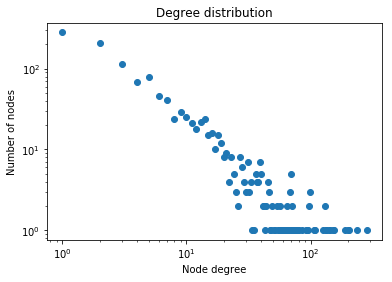

In [72]:
G = nx.Graph()

for index, row in w_edges.iterrows():
    G.add_edge(row['grid1'], row['grid2'], weight=row['count'])

def plotDegreeDistr(graph):
    dh = nx.degree_histogram(graph)
    plt.loglog(dh, linewidth=0, marker='o')
    plt.title("Degree distribution")
    plt.ylabel("Number of nodes")
    plt.xlabel("Node degree")

print(nx.info(G))
plotDegreeDistr(G)

In [46]:
centrality = pd.DataFrame.from_dict(nx.algorithms.degree_centrality(G), orient='index', columns=['centrality']).reset_index()
centrality.columns = ['grid', 'centrality']
centrality.head()

,grid,centrality
0,grid.34477.33,0.1608
1,grid.482139.5,0.2256
2,grid.42629.3b,0.0728
3,grid.147455.6,0.1872
4,grid.116068.8,0.1216


In [47]:
centrality = pd.merge(left=w_nodes, right=centrality, left_on='grid', right_on='grid')
centrality.sort_values('centrality', ascending=False).head(n=10)

,grid,country,continent,centrality
220,grid.482139.5,FR,EU,0.2256
2,grid.147455.6,US,NA,0.1872
4,grid.213917.f,US,NA,0.1616
0,grid.34477.33,US,NA,0.1608
5,grid.466739.9,PT,EU,0.1520
19,grid.214458.e,US,NA,0.1240
3,grid.116068.8,US,NA,0.1216
10,grid.168010.e,US,NA,0.1152
8,grid.266093.8,US,NA,0.1128
17,grid.472568.a,CH,EU,0.1072


In [48]:
box_data = centrality.groupby('country').agg({'centrality': lambda x: list(x)})

data = [go.Box(
            y=row['centrality'],
            name = index,
            boxmean=True
        ) for index, row in box_data.iterrows()]

layout = go.Layout(showlegend=False)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_collaborations_centrality.png')

In [49]:
continental_collab = w_edges[(w_edges.continent1 ==  w_edges.continent2) & (w_edges.country1 !=  w_edges.country2)].groupby(['country1', 'country2', 'continent1', 'continent2', 'lat1', 'lon1', 'lat2', 'lon2']).agg({'count':'sum'}).reset_index()
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler((.1,3))

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(continental_collab[['count']].values.astype(float))

# Run the normalizer on the dataframe
continental_collab['magnitude'] = x_scaled
continental_collab.head()

,country1,country2,continent1,continent2,lat1,lon1,lat2,lon2,count,magnitude
0,AE,KR,AS,AS,23.905282,54.300167,36.385240,127.839161,2,0.111462
1,AT,CH,EU,EU,47.585494,14.126476,46.797859,8.208675,1,0.100000
2,AT,DE,EU,EU,47.585494,14.126476,51.106982,10.385781,7,0.168775
3,AT,DK,EU,EU,47.585494,14.126476,55.981253,10.028010,7,0.168775
4,AT,EE,EU,EU,47.585494,14.126476,58.671930,25.542485,2,0.111462


In [50]:
color_key = {
    'EU': 'blue',
    'AS': 'goldenrod',
    'NA': 'crimson',
    'AF': 'magenta',
    'SA': 'lime',
    'OC': 'cyan'
}

continental_routes = []

groups = set()
for index, row in continental_collab.iterrows():
    if row['country1'] != row['country2']:
        continental_routes.append(dict(
            type = 'scattergeo',
            legendgroup = row['continent1'],
            showlegend = False if row['continent1'] in groups else True,
            name=row['continent1'],
            lat = [ row['lat1'], row['lat2'] ],
            lon = [ row['lon1'], row['lon2'] ],
            mode = 'lines',
            line = dict(
                width = row['magnitude'],
                color = color_key[row['continent1']],
            )))
        groups.add(row['continent1'])
        
map_layout = dict(
    title = 'Continental collaborations',
    showlegend = True,         
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=continental_routes, layout=map_layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_continental_collaborations.png')

In [51]:
intercontinental_collab = w_edges[w_edges.continent1 !=  w_edges.continent2].groupby(['country1', 'country2', 'continent1', 'continent2', 'lat1', 'lon1', 'lat2', 'lon2']).agg({'count':'sum'}).reset_index()
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler((.1,3))

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(intercontinental_collab[['count']].values.astype(float))

# Run the normalizer on the dataframe
intercontinental_collab['magnitude'] = x_scaled
intercontinental_collab.head()

,country1,country2,continent1,continent2,lat1,lon1,lat2,lon2,count,magnitude
0,AE,DK,AS,EU,23.905282,54.300167,55.981253,10.028010,2,0.105675
1,AE,FI,AS,EU,23.905282,54.300167,64.498846,26.274666,2,0.105675
2,AE,US,AS,NA,23.905282,54.300167,45.679547,-112.461674,6,0.128376
3,AR,US,SA,NA,-35.381349,-65.179807,45.679547,-112.461674,1,0.100000
4,AT,AU,EU,OC,47.585494,14.126476,-25.732887,134.491000,8,0.139726


In [52]:
def resolve_color(c1, c2):
    cc = [c1, c2]
    if 'EU' in cc and 'NA' in cc:
        return 'orange'
    if 'EU' in cc and 'AS' in cc:
        return 'cyan'
    if 'EU' in cc and 'SA' in cc:
        return 'yellow'
    if 'EU' in cc and 'OC' in cc:
        return 'darkorchid'
    if 'EU' in cc and 'AF' in cc:
        return 'lime'
    if 'NA' in cc and 'AS' in cc:
        return 'crimson'
    if 'NA' in cc and 'SA' in cc:
        return 'lightblue'
    if 'NA' in cc and 'OC' in cc:
        return 'blue'
    if 'NA' in cc and 'AF' in cc:
        return 'goldenrod'
    if 'AS' in cc and 'OC' in cc:
        return 'magenta'
    if 'AS' in cc and 'AF' in cc:
        return 'gold'
    if 'AS' in cc and 'SA' in cc:
        return 'coral'
    if 'AF' in cc and 'SA' in cc:
        return 'royalblue'
    if 'AF' in cc and 'OC' in cc:
        return 'hotpink'
    if 'OC' in cc and 'SA' in cc:
        return 'seagreen'
    else:
        print('unhandled ', cc)

routes = []
groups = set()
for index, row in intercontinental_collab.iterrows():
    group_name = '-'.join(sorted([row['continent1'], row['continent2']]))
    routes.append(dict(
        type = 'scattergeo',
        name=group_name,
        legendgroup=group_name,
        showlegend = False if group_name in groups else True,
        lat = [ row['lat1'], row['lat2'] ],
        lon = [ row['lon1'], row['lon2'] ],
        mode = 'lines',
        line = dict(
            width = row['magnitude'],
            color = resolve_color(row['continent1'], row['continent2']),
        )))
    groups.add(group_name)
        
map_layout = dict(
    title = 'Intercontinental collaborations',
    showlegend = True,         
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=routes, layout=map_layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_intercontinental_collaborations.png')

## Self-sustaining countries

In [53]:
loners = paper_stats[paper_stats.n_countries == 1].reset_index()
loners['lone_country'] = loners.country.map(lambda x: list(x)[0])

THRESHOLD = 5
loners_data = loners[['lone_country', 'paperid']]\
                .groupby('lone_country')\
                .count()\
                .sort_values(by='paperid', ascending=False).reset_index()
loners_data = loners_data[loners_data.paperid > THRESHOLD]

loners_map = [ dict(
        type = 'choropleth',
        locationmode = 'country names',
        locations = loners_data['lone_country'],
        z = loners_data['paperid'],
        text = loners_data['paperid'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            title = '# papers'),
      ) ]

layout = dict(
    title = 'Self-sustaining countries [with more than %s papers]' % THRESHOLD,
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data=loners_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/chi_loners.png')

## Knowledge debit

In [54]:
debt = pd.merge(left=ref_data, right=cite_data, left_on='country', right_on='country',
                suffixes=('_ref','_cite'), how='outer')
debt = pd.merge(left=debt, right=chi_data, left_on='country', right_on='country',
                suffixes=('_ref','_cite'), how='outer')

debt = debt.fillna(0)
debt['debt'] = debt['paperid_cite'] / debt['paperid_ref']

debt.head()

,country,paperid_ref,paperid_cite,paperid,debt
0,Albania,1.0,6.0,0.0,6.000000
1,Algeria,2.0,21.0,0.0,10.500000
2,Argentina,14.0,151.0,1.0,10.785714
3,Armenia,2.0,0.0,0.0,0.000000
4,Australia,2522.0,5245.0,325.0,2.079699


In [55]:
debt_map = [dict(type='choropleth',
                 locationmode='country names',
                 locations=debt['country'],
                 z=debt['debt'],
                 text=debt['debt'],
                 autocolorscale=True,
                 reversescale=False,
                 marker = dict(line=dict(color='rgb(180,180,180)',
                                         width = 0.5
                                        )
                              ),
                 colorbar=dict(title='Knowledge debit'))]

layout = dict(title='Knowledge debit',
              geo = dict(showframe=False,
                         showcoastlines=True,
                         projection=dict(type='equirectangular')
                        )
             )

fig = go.Figure(data=debt_map, layout=layout)
plotly.offline.iplot(fig, validate=False)
pio.write_image(fig, 'reports/images/chi_knowledge_debit.png')

## Country ranking similarity

In [56]:
year_country_dois = chi_contributions.groupby(['country', 'year'])[['paperid']].nunique()
year_country_dois = year_country_dois.reset_index().pivot(index='country', columns='year', values='paperid')
year_country_dois = year_country_dois.fillna(0).transpose()
year_country_dois.head()

country,Argentina,Australia,Austria,Bangladesh,Belgium,Bermuda,Brazil,Canada,Chile,China,Colombia,Costa Rica,Croatia,Cyprus,Czechia,Denmark,Ecuador,Egypt,Estonia,Finland,France,Germany,Greece,Guatemala,Hungary,Iceland,India,Ireland,Israel,Italy,Japan,Jordan,Kenya,Latvia,Lebanon,Lithuania,Luxembourg,Malaysia,Mali,Malta,Mexico,Namibia,Netherlands,New Zealand,Norway,Pakistan,Panama,Philippines,Poland,Portugal,Qatar,Romania,Russia,Saudi Arabia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,State of Palestine,Sweden,Switzerland,Taiwan,Thailand,Turkey,Uganda,United Arab Emirates,United Kingdom,United States,Vietnam
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,21.0,0.0
1983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,25.0,0.0
1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,0.0
1986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.0
1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0


In [57]:
spearman_coeffs = pd.DataFrame(columns=['correlation', 'pvalue'])
previous = []
for year, row in year_country_dois.iterrows():
    if len(previous) == 0: # first iteration
        previous = row
    else:
        coeff = spearmanr(previous, row)
        spearman_coeffs.loc[year] = [coeff[0], coeff[1]]
        previous = row
spearman_coeffs

,correlation,pvalue
1983,0.764632,5.423284e-15
1985,0.651576,5.705240e-10
1986,0.779946,6.835220e-16
1987,0.578096,1.051231e-07
1988,0.704762,4.876916e-12
1989,0.685297,3.130452e-11
1990,0.631500,2.720513e-09
1991,0.735310,1.907220e-13
1992,0.773878,1.583174e-15
1993,0.731565,2.905587e-13


In [58]:
trace = go.Scatter(x=spearman_coeffs.index,
                    y=spearman_coeffs['correlation'],
                    name='Spearman similarity')

layout = go.Layout(title='Spearman similarity of country rankings',
                   legend=dict(orientation='h'),
                   yaxis=dict(range=[0, 1]))

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_spearman.png')

## First/Last author analysis

In [59]:
chi_contributions.head()

,paperid,year,order,authorid,name,gridid,affiliation,country,countrycode
58161,101198059,2013,3,166732564,olivier chapuis,grid.5328.c,French Institute for Research in Computer Science and Automation,France,FR
42423,101198059,2013,2,2111668110,petra isenberg,grid.5328.c,French Institute for Research in Computer Science and Automation,France,FR
10947,101198059,2013,1,2676222217,anastasia bezerianos,NaN,NaN,NaN,NaN
26685,101198059,2013,4,2085234058,wesley willett,grid.5328.c,French Institute for Research in Computer Science and Automation,France,FR
10503,246191141,2015,1,2091341478,mark cartwright,grid.16753.36,Northwestern University,United States,US


In [60]:
chi_first = chi_contributions[chi_contributions.order == 1]
chi_last_authors_idx = chi_contributions.groupby('paperid')['order'].transform(max) == chi_contributions['order']
chi_last = chi_contributions[chi_last_authors_idx]
chi_middle = chi_contributions[chi_last_authors_idx.map(lambda x: not x)]
chi_middle = chi_middle[chi_middle.order != 1]

In [61]:
chi_last_authors = chi_last[['name', 'paperid']]\
                    .groupby(['name']) \
                    .count().sort_values(by=['paperid'], ascending=False)\
                    .reset_index()
chi_last_authors.head(n=10)

,name,paperid
0,patrick olivier,67
1,hiroshi ishii,64
2,jan o borchers,61
3,stephen a brewster,49
4,brad a myers,48
5,patrick baudisch,44
6,albrecht schmidt,42
7,james a landay,40
8,pattie maes,38
9,george w fitzmaurice,37


In [62]:
first_aff = chi_first.groupby(['year']).agg({'gridid':lambda x: set(x)})
first_aff.columns = ['first_gridId']
first_aff.head()

middle_aff = chi_middle.groupby(['year']).agg({'gridid':lambda x: set(x)})
middle_aff.columns = ['middle_gridId']
middle_aff.head()

last_aff = chi_last.groupby(['year']).agg({'gridid':lambda x: set(x)})
last_aff.columns = ['last_gridId']
last_aff.head()

chi_aff = pd.concat([first_aff, middle_aff, last_aff], axis=1)
chi_aff['n_gridIds'] = chi_aff.apply(lambda row: len_of_set_with_nan(row['first_gridId'] | row['last_gridId'] | row['middle_gridId']), axis=1)
chi_aff['n_first_last'] = chi_aff.apply(lambda row: len_of_set_with_nan(row['first_gridId'] | row['last_gridId']), axis=1)
chi_aff['excluded'] = chi_aff.apply(lambda row: row['middle_gridId'] - (row['first_gridId'] | row['last_gridId']), axis=1)
chi_aff['n_excluded'] = chi_aff['excluded'].map(len_of_set_with_nan)
chi_aff['pct_excluded'] = chi_aff['n_excluded'] / chi_aff['n_gridIds']
chi_aff.head(n=5)

,first_gridId,middle_gridId,last_gridId,n_gridIds,n_first_last,excluded,n_excluded,pct_excluded
year,,,,,,,,
1982,"{nan, grid.482243.b, grid.22072.35, grid.185648.6, grid.21925.3d, grid.89170.37, grid.5600.3, grid.47840.3f, grid.24805.3b, grid.34428.39, grid.264766.7, grid.116068.8, grid.423017.3, grid.89336.37, grid.466739.9, grid.482387.2, grid.253615.6, grid.147455.6, grid.250008.f, grid.14003.36, grid.480193.7, grid.24434.35, grid.61971.38, grid.5335.0, grid.26009.3d, grid.265465.6, grid.7273.1}","{nan, grid.61971.38, grid.21925.3d, grid.5600.3, grid.466739.9, grid.89336.37, grid.14003.36, grid.482387.2}","{nan, grid.482243.b, grid.22072.35, grid.185648.6, grid.21925.3d, grid.89170.37, grid.5600.3, grid.47840.3f, grid.24805.3b, grid.34428.39, grid.264766.7, grid.116068.8, grid.423017.3, grid.89336.37, grid.466739.9, grid.482387.2, grid.253615.6, grid.147455.6, grid.250008.f, grid.14003.36, grid.480193.7, grid.24434.35, grid.61971.38, grid.5335.0, grid.26009.3d, grid.265465.6, grid.7273.1}",26,26,{},0,0.000000
1983,"{nan, grid.482243.b, grid.89170.37, grid.427848.5, grid.438526.e, grid.94365.3d, grid.466739.9, grid.10837.3d, grid.482415.e, grid.5333.6, grid.482387.2, grid.147455.6, grid.134563.6, grid.266100.3, grid.266683.f, grid.47100.32, grid.214458.e, grid.261112.7, grid.25879.31, grid.426471.2, grid.488623.3, grid.35403.31, grid.17063.33}","{nan, grid.47100.32, grid.261112.7, grid.426471.2, grid.466739.9, grid.257127.4, grid.266100.3, grid.482415.e}","{nan, grid.482243.b, grid.89170.37, grid.83440.3b, grid.47840.3f, grid.427848.5, grid.438526.e, grid.94365.3d, grid.268117.b, grid.466739.9, grid.62813.3e, grid.10837.3d, grid.266190.a, grid.482415.e, grid.5333.6, grid.482387.2, grid.147455.6, grid.266100.3, grid.266683.f, grid.47100.32, grid.214458.e, grid.261112.7, grid.25879.31, grid.426471.2, grid.17063.33}",28,27,{grid.257127.4},1,0.035714
1985,"{nan, grid.147455.6, grid.465202.7, grid.34428.39, grid.214458.e, grid.482243.b, grid.47100.32, grid.185648.6, grid.63054.34, grid.116068.8, grid.133342.4, grid.25879.31, grid.466739.9, grid.17063.33, grid.266190.a, grid.5719.a, grid.1453.3}","{grid.482243.b, grid.147455.6, grid.465202.7, grid.34428.39, nan, grid.268091.4, grid.47100.32, grid.250008.f, grid.474412.0, grid.268242.8, grid.116068.8, grid.63054.34, grid.214458.e, grid.168010.e, grid.426471.2, grid.466739.9, grid.17063.33, grid.255364.3, grid.5719.a, grid.254444.7}","{nan, grid.185648.6, grid.133342.4, grid.255364.3, grid.465202.7, grid.34428.39, grid.63054.34, grid.116068.8, grid.33647.35, grid.454363.3, grid.466739.9, grid.17088.36, grid.266190.a, grid.5719.a, grid.1453.3, grid.147455.6, grid.482139.5, grid.47100.32, grid.214458.e, grid.25879.31, grid.17063.33}",28,21,"{grid.268091.4, grid.474412.0, grid.250008.f, grid.268242.8, grid.168010.e, grid.426471.2, grid.254444.7}",7,0.250000
1986,"{nan, grid.482243.b, grid.474709.9, grid.474748.c, grid.260896.3, grid.47840.3f, grid.34477.33, grid.24805.3b, grid.5170.3, grid.465202.7, grid.438526.e, grid.116068.8, grid.19397.35, grid.466739.9, grid.268323.e, grid.266190.a, grid.253615.6, grid.147455.6, grid.166341.7, grid.47100.32, grid.214458.e, grid.266102.1, grid.426471.2, grid.22448.38, grid.21729.3f}","{grid.482243.b, nan, grid.147455.6, grid.9531.e, grid.116068.8, grid.22448.38, grid.454363.3, grid.466739.9, grid.413341.0, grid.17063.33, grid.266190.a, grid.24805.3b, grid.481664.9, grid.429997.8, grid.252858.0, grid.21729.3f}","{nan, grid.482243.b, grid.474709.9, grid.474748.c, grid.260896.3, grid.47840.3f, grid.34477.33, grid.24805.3b, grid.448471.a, grid.465202.7, grid.438526.e, grid.116068.8, grid.19397.35, grid.466739.9, grid.266190.a, grid.147455.6, grid.47100.32, grid.214458.e, grid.266102.1, grid.9531.e, grid.426471.2, grid.22448.38, grid.17063.33, grid.21729.3f}",32,27,"{grid.454363.3, grid.413341.0, grid.481664.9, grid.252858.0, grid.429997.8}",5,0.156250
1987,"{nan, grid.482243.b, grid.46078.3d, grid.474709.9, grid.26090.3d, grid.473728.d, grid.34429.38,

In [63]:
trace1 = go.Scatter(x=chi_aff.index,
                    y=chi_aff['n_gridIds'],
                    name='total gridIDs',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

trace2 = go.Scatter(x=chi_aff.index,
                    y=chi_aff['n_first_last'],
                    name='gridIDs (first & last authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')
                    
trace3 = go.Scatter(x=chi_aff.index,
                    y=chi_aff['n_excluded'],
                    name='gridIDs (middle authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

layout = go.Layout(title="gridIds breakdown by author position",
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_authors_gridids.png')

In [64]:
trace1 = go.Scatter(x=chi_aff.index,
                    y=chi_aff.pct_excluded,
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

layout = go.Layout(title="Percentage of institutions not presenting papers as first/last author's affiliation",
                   legend=dict(orientation='h'),
                   yaxis=dict(range=[-.018, 1]))

fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_excluded_gridids.png')

In [65]:
first_countries = chi_first.groupby(['year']).agg({'country':lambda x: set(x)})
first_countries.columns = ['first_countrycode']
first_countries.head()

middle_countries = chi_middle.groupby(['year']).agg({'country':lambda x: set(x)})
middle_countries.columns = ['middle_countrycode']
middle_countries.head()

last_countries = chi_last.groupby(['year']).agg({'country':lambda x: set(x)})
last_countries.columns = ['last_countrycode']
last_countries.head()

chi_countries = pd.concat([first_countries, middle_countries, last_countries], axis=1)
chi_countries['n_countrycodes'] = chi_countries.apply(lambda row: len_of_set_with_nan(row['first_countrycode'] | row['last_countrycode'] | row['middle_countrycode']), axis=1)
chi_countries['n_first_last'] = chi_countries.apply(lambda row: len_of_set_with_nan(row['first_countrycode'] | row['last_countrycode']), axis=1)
chi_countries['excluded'] = chi_countries.apply(lambda row: row['middle_countrycode'] - (row['first_countrycode'] | row['last_countrycode']), axis=1)
chi_countries['n_excluded'] = chi_countries['excluded'].map(len_of_set_with_nan)
chi_countries['pct_excluded'] = chi_countries['n_excluded'] / chi_countries['n_countrycodes']
chi_countries.head(n=5)

,first_countrycode,middle_countrycode,last_countrycode,n_countrycodes,n_first_last,excluded,n_excluded,pct_excluded
year,,,,,,,,
1982,"{nan, New Zealand, United Kingdom, United States, Portugal, Canada, Netherlands}","{nan, New Zealand, United Kingdom, United States, Portugal, Canada}","{nan, New Zealand, United Kingdom, United States, Portugal, Canada, Netherlands}",6,6,{},0,0.000000
1983,"{nan, New Zealand, United Kingdom, United States, Portugal, Canada, Switzerland, France}","{nan, United States, Portugal, Switzerland, France}","{nan, New Zealand, United Kingdom, United States, Portugal, Canada, Switzerland, France}",7,7,{},0,0.000000
1985,"{nan, United Kingdom, Germany, United States, Poland, Portugal, Canada}","{nan, Germany, United States, Poland, Portugal, Canada, Israel, France}","{nan, United Kingdom, Germany, United States, Poland, Portugal, Canada, France}",8,7,{Israel},1,0.125000
1986,"{nan, Finland, United States, Germany, Poland, Portugal, Denmark, France}","{nan, United Kingdom, United States, Portugal, Canada, Switzerland}","{nan, United Kingdom, Finland, United States, Germany, Poland, Portugal, Canada, France}",10,9,{Switzerland},1,0.100000
1987,"{nan, United States, Germany, Portugal, Sweden, Canada, Netherlands}","{nan, United States, Germany, Portugal, Canada, Sweden, Switzerland, Netherlands}","{nan, United States, Germany, Portugal, Sweden, Canada, Netherlands}",7,6,{Switzerland},1,0.142857


In [66]:
trace1 = go.Scatter(x=chi_countries.index,
                    y=chi_countries['n_countrycodes'],
                    name='total countries',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

trace2 = go.Scatter(x=chi_countries.index,
                    y=chi_countries['n_first_last'],
                    name='countries (first & last authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')
                    
trace3 = go.Scatter(x=chi_countries.index,
                    y=chi_countries['n_excluded'],
                    name='countries (middle authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

layout = go.Layout(title='Countries breakdown by author position',
                   legend=dict(orientation='h'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_authors_countries.png')

In [67]:
trace1 = go.Scatter(x=chi_countries.index,
                    y=chi_countries.pct_excluded,
                    marker=dict(symbol='circle'),
                    mode='lines+markers')

layout = go.Layout(title="Percentage of countries not presenting papers as first/last author's affiliation",
                   legend=dict(orientation='h'),
                   yaxis=dict(range=[-.018, 1]))

fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)
pio.write_image(fig, 'reports/images/chi_excluded_countries.png')